In [1]:
from os import environ, path
from absl import logging as absl_logging
from IPython.display import clear_output
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import ParameterSampler
import os
from pathlib import Path
from glob import glob
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
# import keras_c

2023-11-27 13:21:49.722621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 13:21:49.722687: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 13:21:49.724087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 13:21:49.855139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##Variables
IMAGE_SIZE = 128
BATCH_SIZE = 8
NUM_CLASSES = 104
LEARNING_RATE=0.002
WEIGHT_DECAY=0.0001
MOMENTUM=0.9
CLIPNORM=10.0


EPOCHS=25

In [18]:
if os.getenv("COLAB_RELEASE_TAG"):
    isInColab = True
else:
    isInColab = False

if isInColab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_folder_path = Path(os.getcwd() + r"/gdrive/My Drive/FoodSeg103/Images")
    models_path = Path(os.getcwd() + r"/gdrive/My Drive/Models")
else:
    data_folder_path = Path(os.getcwd()+ r"/Dataset/FoodSeg103/Images")
    models_path = Path(os.getcwd() + r"/Models")
try:
    os.mkdir(models_path)
    print("Models folder created for saving models")
except:
    print("Models folder already exists")


Models folder already exists


In [37]:
##Data loading
def load_images_combined(NUM_TRAIN_IMAGES, NUM_VAL_IMAGES):
    train_images_path = os.path.join(data_folder_path, r"img_dir/train")
    train_ann_path = os.path.join(data_folder_path, r"ann_dir/train")
    test_images_path = os.path.join(data_folder_path, r"img_dir/test")
    test_ann_path = os.path.join(data_folder_path, r"ann_dir/test")
    train_images_paths = sorted(os.listdir(train_images_path))
    train_ann_paths = sorted(os.listdir(train_ann_path))
    test_images_paths = sorted(os.listdir(test_images_path))
    test_ann_paths = sorted(os.listdir(test_ann_path))

    train_images = train_images_paths[:NUM_TRAIN_IMAGES]
    train_masks = train_ann_paths[:NUM_TRAIN_IMAGES]
    val_images = test_images_paths[:NUM_VAL_IMAGES]
    val_masks = test_ann_paths[:NUM_VAL_IMAGES]

    train_images = [str(os.path.join(train_images_path, img)) for img in train_images]
    train_masks = [str(os.path.join(train_ann_path, img)) for img in train_masks]
    val_images = [str(os.path.join(test_images_path, img)) for img in val_images]
    val_masks = [str(os.path.join(test_ann_path, img)) for img in val_masks]

    image_paths=train_images+val_images
    mask_paths=train_masks+val_masks
    image_paths.sort()
    mask_paths.sort()
    # images={
    #     "image": train_images+val_images,
    #     "masks": train_masks+val_masks
    # }
    return image_paths, mask_paths

image_paths, mask_paths = load_images_combined(4983, 2135)
# dataset = tf.data.Dataset.from_tensor_slices((images['image'], images['masks']))


In [45]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from keras.utils import to_categorical
import numpy as np
from PIL import Image

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, validation_split=0.2):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.on_epoch_end()

    def on_epoch_end(self):
        # Split the data into training and validation sets
        self.train_image_paths, self.val_image_paths, self.train_mask_paths, self.val_mask_paths = \
            train_test_split(self.image_paths, self.mask_paths, test_size=self.validation_split, random_state=42)

    def __len__(self):
        return int(np.ceil(len(self.train_image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_x, batch_y = self.load_data(start, end)

        # Optionally repeat the dataset
        if end == len(self.train_image_paths):
            self.on_epoch_end()  # Reset at the end of an epoch

        return batch_x, batch_y
        
        # start = index * self.batch_size
        # end = (index + 1) * self.batch_size
        # batch_x, batch_y = self.load_data(start, end)
        # return batch_x, batch_y

    def load_data(self, start, end):
        # Load and preprocess data
        batch_x = []
        batch_y = []
        paths = self.train_image_paths  # Use training paths during training
        # max_pixel_value = 0
        for i in range(start, min(end, len(self.image_paths))):
            # Load and preprocess image
            img_img = tf.io.read_file(self.image_paths[i])
            img = tf.image.decode_png(img_img, channels=3)
            img.set_shape([None, None, 3])
            img = tf.image.resize(images=img, size=[IMAGE_SIZE, IMAGE_SIZE])
            img = tf.keras.applications.resnet50.preprocess_input(img)
            batch_x.append(img)

            # Load and preprocess mask
            mask_img = tf.io.read_file(self.mask_paths[i])
            mask = tf.image.decode_png(mask_img, channels=1)
            mask.set_shape([None, None, 1])
            mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
            one_hot_mask=to_categorical(mask,num_classes=NUM_CLASSES)
            # max_value_in_image = np.max(mask)
            # max_pixel_value = max(max_pixel_value, max_value_in_image)
            batch_y.append(one_hot_mask)
        # print("Overall Maximum Pixel Value:", max_pixel_value)
        return np.array(batch_x), np.array(batch_y)


train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2)

# Create instances of your custom data generator for training and validation
train_data_generator = CustomDataGenerator(train_image_paths, train_mask_paths, batch_size=BATCH_SIZE)
val_data_generator = CustomDataGenerator(val_image_paths, val_mask_paths,  batch_size=BATCH_SIZE)

# data_generator = CustomDataGenerator(image_paths, mask_paths)

In [46]:
##The model
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", kernel_initializer=keras.initializers.HeNormal())(x)
    # model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    # Adjust the number of output channels to match the number of classes
    x_out = layers.Conv2D(104, (1, 1), activation='softmax')(x)

    # Use a Reshape layer to match the output shape to (height, width, num_classes)
    x_out = layers.Reshape((image_size, image_size, 104))(x_out)


    return keras.Model(inputs=model_input, outputs=x_out)



In [55]:
print(len(train_image_paths))
print(len(val_image_paths))

1424 + 5694
print(len(train_image_paths) // BATCH_SIZE)
print(len(val_image_paths) // BATCH_SIZE)
print(17775 // 25)

5694
1424
711
178
711


In [24]:
model=DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.002, weight_decay=0.0001, momentum=0.9, clipnorm=10.0),
      loss=keras.losses.CategoricalCrossentropy(from_logits=False),
      metrics=[
          keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES, ignore_class=0),
          keras.metrics.CategoricalAccuracy(),
      ])
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(train_image_paths)//BATCH_SIZE,
    # steps_per_epoch=500,
    epochs=EPOCHS,
    validation_data=val_data_generator,
    validation_steps=len(val_image_paths)//BATCH_SIZE
    # validation_steps=125
    )

Epoch 1/25
570/711 [=======================>......] - ETA: 28s - loss: 2.1343 - one_hot_mean_io_u_1: 0.0258 - categorical_accuracy: 0.5350

2023-11-27 13:35:35.582057: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12094384989605534130
2023-11-27 13:35:35.582119: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17014484570836317922
2023-11-27 13:35:35.582129: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10197571004204363545
2023-11-27 13:35:35.582135: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14637221559000373045


711/711 [==============================] - 157s 198ms/step - loss: 2.1343 - one_hot_mean_io_u_1: 0.0258 - categorical_accuracy: 0.5350 - val_loss: 1.6944 - val_one_hot_mean_io_u_1: 0.0548 - val_categorical_accuracy: 0.5987


2023-11-27 13:36:00.846802: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5633156238226856114
2023-11-27 13:36:00.846864: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13243949958192383302
2023-11-27 13:36:00.846871: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 140480356009411277
2023-11-27 13:36:00.846875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17241032318158015599


In [68]:
from datetime import datetime
def saveModel(model, history):
    dt_string = datetime.now().strftime("%d%m%Y-%H:%M:%S")
    save_name = "model_" + dt_string
    folder_save_path = os.path.join(models_path, Path(save_name))
    os.mkdir(folder_save_path)
    his_save_path = os.path.join(folder_save_path, Path(r"history.npy"))
    model_save_path = os.path.join(folder_save_path, Path(r"model.keras"))
    np.save(his_save_path,history)
    model.save(model_save_path)

saveModel(model, history)

In [27]:
class_labels={0:'background',1:'candy',2:'egg tart',3:'french fries',4:'chocolate',5:'biscuit',6:'popcorn',7:'pudding',8:'ice cream',9:'cheese butter',10:'cake',11:'wine',12:'milkshake',13:'coffee',14:'juice',15:'milk',16:'tea',17:'almond',18:'red beans',19:'cashew',20:'dried cranberries',21:'soy',22:'walnut',23:'peanut',24:'egg',25:'apple',26:'date',27:'apricot',28:'avocado',29:'banana',30:'strawberry',31:'cherry',32:'blueberry',33:'raspberry',34:'mango',35:'olives',36:'peach',37:'lemon',38:'pear',39:'fig',40:'pineapple',41:'grape',42:'kiwi',43:'melon',44:'orange',45:'watermelon',46:'steak',47:'pork',48:'chicken duck',49:'sausage',50:'fried meat',51:'lamb',52:'sauce',53:'crab',54:'fish',55:'shellfish',56:'shrimp',57:'soup',58:'bread',59:'corn',60:'hamburg',61:'pizza',62:' hanamaki baozi',63:'wonton dumplings',64:'pasta',65:'noodles',66:'rice',67:'pie',68:'tofu',69:'eggplant',70:'potato',71:'garlic',72:'cauliflower',73:'tomato',74:'kelp',75:'seaweed',76:'spring onion',77:'rape',78:'ginger',79:'okra',80:'lettuce',81:'pumpkin',82:'cucumber',83:'white radish',84:'carrot',85:'asparagus',86:'bamboo shoots',87:'broccoli',88:'celery stick',89:'cilantro mint',90:'snow peas',91:' cabbage',92:'bean sprouts',93:'onion',94:'pepper',95:'green beans',96:'French beans',97:'king oyster mushroom',98:'shiitake',99:'enoki mushroom',100:'oyster mushroom',101:'white button mushroom',102:'salad',103:'other ingredients'}

def predict(model, images, index, useTrainingImages):
    ImageIndex = index

    if useTrainingImages:
      img_path = images["train_images"][ImageIndex]
      ann_path = images["train_masks"][ImageIndex]
    else:
      img_path = images["val_images"][ImageIndex]
      ann_path = images["val_masks"][ImageIndex]

    processed_image = read_image(img_path)[None,:,:,:]
    result = model.predict(processed_image)
    result = result.squeeze()
    return result


def plot_images_withLegends(image_number):
  image = cv2.resize(cv2.cvtColor(cv2.imread(val_image_paths[image_number]), cv2.COLOR_BGR2RGB), dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
  mask_img = tf.io.read_file(val_mask_paths[image_number])
  # mask = read_image(val_mask_paths[image_number])
  mask = tf.image.decode_png(mask_img, channels=1)
  mask.set_shape([None, None, 1])
  mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
  one_hot_mask=to_categorical(mask,num_classes=NUM_CLASSES)
  prediction=  predict(model, images, image_number, True)

  colormap = plt.cm.get_cmap('viridis', len(class_labels))  # Use the number of unique classes
  # Convert RGB to grayscale if needed
  if len(mask.shape) == 3:
      mask = np.mean(mask, axis=-1)

  # Convert selected channel to grayscale
  predicted_classes = prediction.argmax(axis=-1)

# Get unique class indices present in the image
  unique_classes = np.unique(predicted_classes)

  # Convert to RGB using the colormap
  rgb_image = colormap(predicted_classes)[:, :, :3]

  # Convert RGB to grayscale
  gray_image = np.mean(rgb_image, axis=-1)

  # Display the result with dynamic legend
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Display the normal image with colors
  axes[0].imshow(image, cmap='viridis')
  axes[0].axis('off')
  axes[0].set_title('Normal Image')

  # Display the mask image as grayscale
  axes[1].imshow(mask, cmap='gray')
  axes[1].axis('off')
  axes[1].set_title('Mask Image (Grayscale)')

  # Display the prediction image for the selected class as grayscale
  axes[2].imshow(gray_image, cmap='gray')
  axes[2].axis('off')
  axes[2].set_title(f'Prediction (Grayscale) for Class')

  # Create a dynamic legend for unique classes in the prediction image
  colormapLegend = plt.cm.get_cmap('gray', 104)
  unique_classes = np.unique(predicted_classes)
  # legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label=class_labels[int(j)]) for j in range(len(unique_classes))]
  legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormapLegend(i)[:3], markersize=10, label=class_labels[i]) for i in unique_classes]
  ax_inset = axes[2].inset_axes([1.05, 0, 0.2, 1])
  ax_inset.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0, 0.5))
  ax_inset.axis('off')


  plt.show()

In [26]:
plot_images_withLegends(5)

NameError: ignored

In [12]:
 max_pixel_value = 0

 for image_path in mask_paths:
  # Load and preprocess image
  # img_img = tf.io.read_file(self.image_paths[i])
  # img = tf.image.decode_png(img_img, channels=3)
  # img.set_shape([None, None, 3])
  # img = tf.image.resize(images=img, size=[IMAGE_SIZE, IMAGE_SIZE])
  # img = tf.keras.applications.resnet50.preprocess_input(img)
  # batch_x.append(img)

  # Load and preprocess mask
  mask_img = tf.io.read_file(image_path)
  mask = tf.image.decode_png(mask_img, channels=1)
  mask.set_shape([None, None, 1])
  mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
  max_value_in_image = np.max(mask)
  max_pixel_value = max(max_pixel_value, max_value_in_image)
  # batch_y.append(mask)

print("Overall Maximum Pixel Value:", max_pixel_value)

Overall Maximum Pixel Value: 103


In [ ]:


def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

##todo maybe the colors should be checked
def load_and_preprocess_mask(mask_path):
  image = tf.io.read_file(mask_path)
  image = tf.image.decode_png(image, channels=1)
  image.set_shape([None, None, 1])
  image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
  return image

def load_and_preprocess_data(image_path, mask_path):
    # Load and preprocess your images and masks
    # You may need to resize, normalize, or apply other preprocessing steps
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)
    return image, mask

dataset = dataset.map(load_and_preprocess_data)



In [ ]:
##the model
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", kernel_initializer=keras.initializers.HeNormal())(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
train_size = int(0.8 * len(images['image']))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
model = DeeplabV3Plus(IMAGE_SIZE, NUM_CLASSES)

# Define a custom mIoU metric
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes):
        super(MeanIoU, self).__init__(num_classes=num_classes)

mean_iou_metric = MeanIoU(NUM_CLASSES)

# Compile the model with the custom metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', mean_iou_metric])

model.fit(train_dataset, steps_per_epoch=10, epochs=10,validation_data=val_dataset)
model.evaluate(test_generator)

# Access the mean IoU value
mean_iou_value = mean_iou_metric.result().numpy()


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10


ValueError: ignored

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

# Path to your dataset
dataset_path = Path(os.getcwd() + r"/gdrive/My Drive/FoodSeg103/Images/img_dir")

def custom_data_generator(image_folder, mask_folder, batch_size=32, target_size=(256, 256)):
    image_datagen = ImageDataGenerator(rescale=1./255)
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        image_folder,
        class_mode=None,
        target_size=target_size,
        batch_size=batch_size,
        seed=42
    )

    mask_generator = mask_datagen.flow_from_directory(
        mask_folder,
        class_mode=None,
        target_size=target_size,
        batch_size=batch_size,
        seed=42,
        color_mode='grayscale'
    )

    while True:
        image_batch = image_generator.next()
        mask_batch = mask_generator.next()
        yield image_batch, mask_batch

# Create a custom data generator for both train and test
train_generator = custom_data_generator(os.path.join(dataset_path, 'train'), os.path.join(dataset_path, 'masks'))
test_generator = custom_data_generator(os.path.join(dataset_path, 'test'), os.path.join(dataset_path, 'masks'))

# Extract one batch for debugging
sample_batch_train = next(train_generator)
sample_images_train, sample_masks_train = sample_batch_train[0], sample_batch_train[1]

sample_batch_test = next(test_generator)
sample_images_test, sample_masks_test = sample_batch_test[0], sample_batch_test[1]

# Now, the shape of sample_images_train/masks_train and sample_images_test/masks_test should be (32, 256, 256, 3) and (32, 256, 256, 1) respectively
print(sample_images_train.shape, sample_masks_train.shape)
print(sample_images_test.shape, sample_masks_test.shape)

Found 0 images belonging to 0 classes.


FileNotFoundError: ignored

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
dataset_path = Path(os.getcwd() + r"/gdrive/My Drive/FoodSeg103/Images/img_dir")

# Create an ImageDataGenerator for images
image_datagen = ImageDataGenerator(rescale=1./255)
image_generator = image_datagen.flow_from_directory(
    dataset_path=,
    classes=['train', 'test'],  # Include both 'train' and 'test' folders
    class_mode=None,
    target_size=(256, 256),  # Adjust the target size based on your model input size
    batch_size=32,
    seed=42
)

TypeError: ignored

In [ ]:
def train_model_new():
  model=DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
  model.compile(
    optimizer=keras.optimizers.SGD(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, clipnorm=CLIPNORM
    ),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
    ])
  history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)
  return (model, history)

t= train_model_new()

NameError: ignored

In [ ]:
images = load_images_combined(10,10)

In [ ]:
train_size = int(0.8 * len(images['image']))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Batch and shuffle the training dataset
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Batch the validation dataset
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
singleMask=load_and_preprocess_mask(images['masks'][0])
ar

Image Shape: (384, 512, 1)
Image Data Type: <dtype: 'float32'>


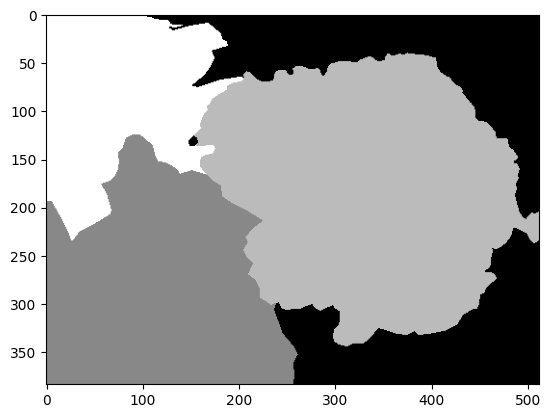

In [ ]:
img_raw = tf.io.read_file(images['masks'][0])

# Decode the image, specifying the channels (1 for grayscale)
img_tensor = tf.io.decode_image(img_raw, channels=1, dtype=tf.uint8)

# Convert the image to float32 and normalize it to the range [0, 1]
img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
img_tensor = img_tensor / 103.0  # Assuming the original range is [0, 103]

# Print information about the loaded image
print("Image Shape:", img_tensor.shape)
print("Image Data Type:", img_tensor.dtype)

# Display the image using matplotlib or any other plotting library
import matplotlib.pyplot as plt

plt.imshow(tf.squeeze(img_tensor), cmap='gray')
plt.show()

In [ ]:
##model
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", kernel_initializer=keras.initializers.HeNormal())(x)
    return keras.Model(inputs=model_input, outputs=model_output)


def trainModel(Epochs):
    model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    model.compile(
      optimizer=keras.optimizers.SGD(
          learning_rate=0.002, weight_decay=0.0001, momentum=0.9, clipnorm=10.0
      ),
      loss=keras.losses.CategoricalCrossentropy(from_logits=False),
      metrics=[
          keras.metrics.MeanIoU(
              num_classes=NUM_CLASSES, sparse_y_true=False, sparse_y_pred=False
          ),
          keras.metrics.CategoricalAccuracy(),
      ],)
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=Epochs)
    return (model, history)


def trainNewModel(Epochs):
    #Train new model and history
    model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=None)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.002),
        loss=loss,
        # metrics=[keras.metrics.MeanIoU(
        #     num_classes=NUM_CLASSES, sparse_y_true=False, sparse_y_pred=False
        # ),
        # keras.metrics.CategoricalAccuracy(),],
        metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES,ignore_class=0)],
        # metrics=["accuracy"],
    )
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=Epochs)
    return (model, history)


In [ ]:
def train_model_mean_iou(Epochs):
    model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    model.compile(
      optimizer=keras.optimizers.SGD(
          learning_rate=0.002, weight_decay=0.0001, momentum=0.9, clipnorm=10.0
      ),
      loss=keras.losses.CategoricalCrossentropy(from_logits=False),
      metrics=[
          keras.metrics.MeanIoU(
              num_classes=NUM_CLASSES, sparse_y_true=False, sparse_y_pred=False
          ),
          keras.metrics.CategoricalAccuracy(),
      ],)
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=Epochs)
    return (model, history)


## load data in new manner
#loading array with image paths
image_paths, mask_paths = load_images_combined(100, 10)

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

def load_and_preprocess_mask(mask_path):


def load_and_preprocess_data(image_path, mask_path):
    # Load and preprocess your images and masks
    # You may need to resize, normalize, or apply other preprocessing steps
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)
    return image, mask

# def load_and_preprocess_image(image_path):
#     # Implement image loading and preprocessing (e.g., resizing)
#     # Return the preprocessed image as a NumPy array
#     return processed_image

def load_and_preprocess_mask(mask_path):
    # Implement mask loading and preprocessing (e.g., resizing)
    # Return the preprocessed mask as a NumPy array
    return processed_mask

# Load and preprocess the data
data = [load_and_preprocess_data(image_path, mask_path) for image_path, mask_path in zip(image_paths, mask_paths)]
images, masks = zip(*data)

IndentationError: ignored

In [ ]:
##loading model
def loadModel(ModelPath):
    print("Input the folder of the model to load (the folder should be in the models folder and include a history.npy file and a model.keras file):")
    # load_name = input()
    folder_load_path = os.path.join(models_path, Path(ModelPath))
    his_load_path = os.path.join(folder_load_path, Path(r"history.npy"))
    model_load_path = os.path.join(folder_load_path, Path(r"model.keras"))
    history=np.load(his_load_path,allow_pickle='TRUE').item()
    model = keras.models.load_model(model_load_path)
    return (model, history)

model, history = loadModel("Base")

Input the folder of the model to load (the folder should be in the models folder and include a history.npy file and a model.keras file):
